### Experiment goals
Determine features that differentiate across:  
    1) Data types  
    2) Cancer model types  
    3) Tissues-of-origin (Cancer Types)  

In [ ]:
# This notebook:
    # write averaged and transposed expression file to disk
        # for read-in by 3 feature selection methods
    # write binary and ternary response objects to disk

# Update - pairs patch code file removes duplicates for canSMILES that map
# to multiple drug ids

### Imports

In [16]:
import math
import numpy as np
import pandas as pd
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import collections

In [14]:
ls *.gz

copy_number.csv.gz  drugs.tsv.gz        experiments.tsv.gz  expression.csv.gz


In [15]:
ls *.csv

genes.csv       mutations.csv   samples.csv     test_data.csv   train_data.csv


### Average counts for duplicate genes

In [ ]:
# Send to diff, UMAP, and VAE feature methods after averaging

In [12]:
exp_df = pd.read_csv('expression.csv.gz')
exp_df_lite = exp_df.iloc[:, :3] # remove study and source cols
del(exp_df)

In [ ]:
# Average expression values of duplicate genes
# within each improve sample
# Run time is about 6 - 7 minutes
# Result is removal of ~1.3M genes, ~5% of file

# List for each new column
e_lst = []
i_lst = []
c_lst = []

# Improve sample loop, 1007 total
for smp_id in exp_df_lite.improve_sample_id.unique():
    sub = exp_df_lite[exp_df_lite.improve_sample_id == smp_id]
    single_list = [] # only populate with gene id if unique occurance
    for index, value in sub.entrez_id.value_counts().items():
        
        if value > 1:

            sub_sub = sub[sub.entrez_id == index]
            e_lst.append(index)
            i_lst.append(smp_id)
            c_lst.append(sub_sub.counts.mean())
        else:
            single_list.append(index) # only add single expression count below
                                      # if averaged counts list not modded above
    c_lst = c_lst + list(sub[sub.entrez_id.isin(single_list)].counts)
    i_lst = i_lst + list(sub[sub.entrez_id.isin(single_list)].improve_sample_id)
    e_lst = e_lst + list(sub[sub.entrez_id.isin(single_list)].entrez_id)
exp_avrgd = pd.DataFrame({'entrez_id': e_lst, 'improve_sample_id': i_lst, 'counts': c_lst})

In [119]:
exp_avrgd.to_csv('disk_chkpnts_tssue/exp_avrgd.tsv', sep = '\t')

In [17]:
# Checkpoint
exp_avrgd = pd.read_csv('disk_chkpnts_tssue/exp_avrgd.tsv', sep = '\t', index_col = 0)

### Intersection of genes across IMPROVE samples

In [19]:
gene_vectors = []
for smp_id in exp_avrgd.improve_sample_id.unique():
    sub = exp_avrgd[exp_avrgd.improve_sample_id == smp_id]
    sub_gene_list = list(sub.entrez_id)
    gene_vectors.append(sub_gene_list)

In [20]:
ntrsct = set.intersection(*map(set,gene_vectors))

In [21]:
len(ntrsct)

30888

### Transpose into IMPROVE samples x genes

In [22]:
exprsn_dot_T = pd.DataFrame()
for smp_id in exp_avrgd.improve_sample_id.unique():
    sub = exp_avrgd[exp_avrgd.improve_sample_id == smp_id]
    transposed_df = sub.pivot(
        index='improve_sample_id',
        columns='entrez_id',
        values='counts')
    exprsn_dot_T = pd.concat([exprsn_dot_T, transposed_df])

In [28]:
exprsn_dot_T.to_csv('AUC_v1/exprsn_dot_T.tsv',
                  sep = '\t')
# To three feature selection methods

### Build summary AUC inner join object

In [25]:
xpr_df = pd.read_csv('experiments.tsv.gz', sep = '\t')
xpr_auc = xpr_df[['improve_sample_id', 'improve_drug_id', 'AUC']].copy()
xpr_check = xpr_auc[['improve_sample_id', 'improve_drug_id']].copy()
xpr_check.drop_duplicates(inplace = True)
unq_pairs = xpr_auc[xpr_auc.index.isin(xpr_check.index)]

In [24]:
drg_df = pd.read_csv('drugs.tsv.gz', sep = '\t')
drg_canSMI = drg_df[['canSMILES', 'improve_drug_id']].copy()
drg_canSMI.dropna(inplace=True)
drg_canSMI.drop_duplicates(inplace = True)

In [26]:
inner_join_AUC = unq_pairs.merge(drg_canSMI, how="inner", on="improve_drug_id")

In [29]:
inner_join_AUC.to_csv('AUC_v1/inner_join_AUC.tsv', sep = '\t')

### Binarize and trinarize the response scores

In [63]:
inner_join_AUC = pd.read_csv('AUC_v1/inner_join_AUC.tsv',
                            sep = '\t',
                            index_col = 0)

In [64]:
inner_join_AUC.rename(
    columns={col: str(col) for col in inner_join_AUC.columns}, inplace=True)

In [65]:
del inner_join_AUC['improve_drug_id']

Text(0.5, 1.0, 'AUC, merged PhrmGx drg rspns')

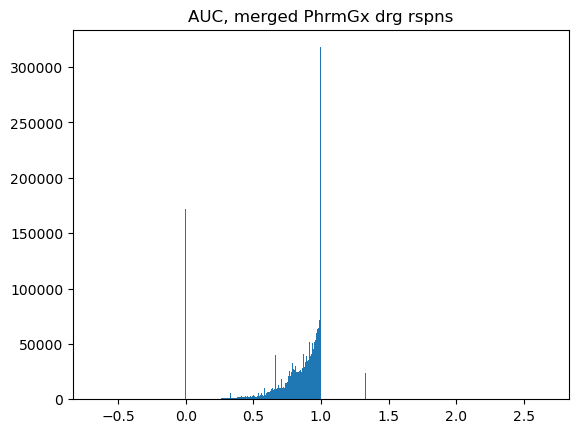

In [46]:
plt.hist(inner_join_AUC.AUC, bins = 800)
plt.title('AUC, merged PhrmGx drg rspns')

In [66]:
inner_join_AUC = inner_join_AUC[inner_join_AUC['AUC'].between(0, 1)]

Text(0.5, 1.0, 'AUC, merged PhrmGx drg rspns')

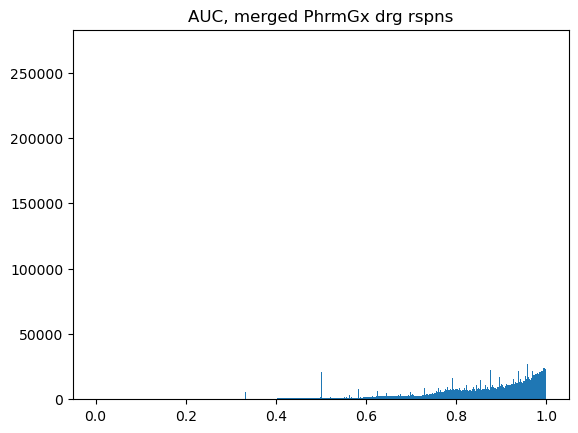

In [48]:
plt.hist(inner_join_AUC.AUC, bins = 800)
plt.title('AUC, merged PhrmGx drg rspns')

In [51]:
inner_join_AUC.AUC.min()

0.0

In [52]:
inner_join_AUC.AUC.max()

1.0

#### binarize

In [55]:
binary_list = []
for auc in inner_join_AUC.AUC:
    if auc > .95:
        binary_list.append('high')
    elif auc < .8:
        binary_list.append('low')
    else:
        binary_list.append('delete')

In [59]:
inner_join_AUC.AUC = binary_list

In [60]:
inner_join_AUC = inner_join_AUC[~inner_join_AUC.AUC.str.contains('delete')]

In [62]:
inner_join_AUC.to_csv('AUC_v1/inner_join_AUC_binary.tsv', sep = '\t')

#### trinarize

In [67]:
trinary_list = []
for auc in inner_join_AUC.AUC:
    if auc > .95:
        trinary_list.append('high')
    elif auc < .5:
        trinary_list.append('low')
    else:
        trinary_list.append('med')

In [68]:
inner_join_AUC.AUC = trinary_list

In [70]:
inner_join_AUC.to_csv('AUC_v1/inner_join_AUC_trinary.tsv', sep = '\t')

In [ ]:
# To feature set merges on front-end of transformer